### 1. Introduction

In this project, we will work with the S&P 500, a key benchmark index for investors worldwide.  The dataset comprises historial S&P 500 info from 1950 to 2015.  

The columns of the dataset are:
- Date - The date of the record.
- Open - The opening price of the day (when trading starts).
- High - The highest trade price during the day.
- Low - The lowest trade price during the day.
- Close - The closing price for the day (when trading ends).
- Volume - The number of shares traded.
- Adj Close - The daily closing price, adjusted retroactively to accounts for any corporate actions.

We will use this dataset to develop a predictive model.  The train set uses the data from 1950-2012, while the test set uses data from 2013-2015.

Disclaimer: This notebook is purely for demo purposes, and does not constitutes stock trading or investment advice.

### 2. Opening the dataset

We start by importing the numpy, pandas, datetime, and sklearn libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
df = pd.read_csv('sphist.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by ascending date order
df = df.sort_values(by=['Date'],ascending=True)
print(df.head())

            Date   Open   High    Low  Close     Volume  Adj Close
16589 1950-01-03  16.66  16.66  16.66  16.66  1260000.0      16.66
16588 1950-01-04  16.85  16.85  16.85  16.85  1890000.0      16.85
16587 1950-01-05  16.93  16.93  16.93  16.93  2550000.0      16.93
16586 1950-01-06  16.98  16.98  16.98  16.98  2010000.0      16.98
16585 1950-01-09  17.08  17.08  17.08  17.08  2520000.0      17.08


### 3. Generating indicators

For this exercise, we will use simple moving averages (SMA) for 5, 30 and 365 days.  Frist we create 3 blank columns:

In [2]:
df['day_5'] = 0
df['day_30'] = 0
df['day_365'] = 0
df.iloc[:10,5:]

,Volume,Adj Close,day_5,day_30,day_365
16589,1260000.0,16.660000,0,0,0
16588,1890000.0,16.850000,0,0,0
16587,2550000.0,16.930000,0,0,0
16586,2010000.0,16.980000,0,0,0
16585,2520000.0,17.080000,0,0,0
16584,2160000.0,17.030001,0,0,0
16583,2630000.0,17.090000,0,0,0
16582,2970000.0,16.760000,0,0,0
16581,3330000.0,16.670000,0,0,0
16580,1460000.0,16.719999,0,0,0


Using time series tools in pandas: <br>
Next, we populate the 3 indicator columns using the .rolling().mean() method.
To prevent look-ahead bias, we also apply the .shift() method to shift the moving averages back by one day.  <br>
If done correctly, the 5-day moving average would begin on day 6, etc.

In [3]:
df['day_5'] = df['Close'].rolling(5).mean()
df['day_5'] = df['day_5'].shift()
df['day_30'] = df['Close'].rolling(30).mean()
df['day_30'] = df['day_30'].shift()
df['day_365'] = df['Close'].rolling(365).mean()
df['day_365'] = df['day_365'].shift()
print(df.shape)
df.iloc[:10,5:]

(16590, 10)


,Volume,Adj Close,day_5,day_30,day_365
16589,1260000.0,16.660000,NaN,NaN,NaN
16588,1890000.0,16.850000,NaN,NaN,NaN
16587,2550000.0,16.930000,NaN,NaN,NaN
16586,2010000.0,16.980000,NaN,NaN,NaN
16585,2520000.0,17.080000,NaN,NaN,NaN
16584,2160000.0,17.030001,16.900,NaN,NaN
16583,2630000.0,17.090000,16.974,NaN,NaN
16582,2970000.0,16.760000,17.022,NaN,NaN
16581,3330000.0,16.670000,16.988,NaN,NaN
16580,1460000.0,16.719999,16.926,NaN,NaN


### 4. Cleaning up the data

As can be seen from the above df index slice, the day_5, day_30 and	day_365 column produced a number of NaN values, as these rows do not have enough historical data to generate them.  In particular, given that the dataset started on 1950-01-03, any rows that fall before 1951-01-03 would have NaN values for day_365 (the 365-day moving average).

In [4]:
df = df.dropna(axis = 0)
print(df.shape)
df.head()

(16225, 10)


,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082


After cleaning up the NaN rows, we find that 365 rows were dropped as a result (from 16590 rows to 16225 rows).

### 5. Splitting data into test and train sets
#### 5.1 - Test set
Our test set is defined as dates greater than or equal to 2013-01-01, while the train set contains rows in the data before 2013-01-01.

In [5]:
# test set : greater than or equal to 2013-01-01
# apply a date boolean operator
a = df['Date']>=datetime(year=2013,month=1,day=1)
a.tail()

4    True
3    True
2    True
1    True
0    True
Name: Date, dtype: bool

From the cell below we can see the boolean operator works properly and the test set starts from 2013-01-02. <br> Note: 2013-01-01 is not a trading day as it is New Year's Day.

In [6]:
# filter dates based on boolean operator in last cell
test = df[a]
test.head()

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877
735,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617
734,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603


In [7]:
b = df['Date']<datetime(year=2013,month=1,day=1)
b.head()

16224    True
16223    True
16222    True
16221    True
16220    True
Name: Date, dtype: bool

#### 5.2 - Train set
For the train set, we check that the boolean operator works correctly, as the train set dates end before 2013-01-01:

In [8]:
train = df[b]
train.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365
743,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,1437.360010,1405.926001,1326.114028
742,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,1436.620019,1407.486336,1326.412494
741,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1408.813000,1326.716494
740,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,1427.685986,1410.265332,1326.995836
739,2012-12-31,1402.430054,1426.739990,1398.109985,1426.189941,3.204330e+09,1426.189941,1419.434009,1411.830001,1327.261562


### 6. Linear Regression

We use the 3 moving average indicators we have created to perform Linear Regression against the S&P 500 index, as well as testing a combinination indicators to quantify the improvement in predictive accuracy, if any.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt 

In [10]:
indicator_1 = 'day_5'
indicator_2 = 'day_30'
indicator_3 = 'day_365'
indicator_4 = 'day_5, day_30'
indicator_5 = 'day_5, day_30, day_365'

#### indicator_1 = 'day_5'

day_5 mean_absolute_error: 16.267878754475266
day_5 mean_squared_error: 493.2698288743041


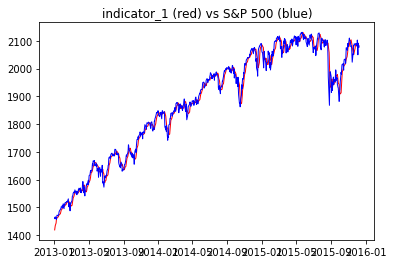

In [11]:
lr = LinearRegression()
lr.fit(train[['day_5']],train[['Close']])
pre = lr.predict(test[['day_5']])

# print(indicator_1, 'coef:', lr.coef_)
# print(indicator_1, 'intercept:', lr.intercept_)

mae_1 = mean_absolute_error(test['Close'],pre)
print(indicator_1,'mean_absolute_error:', mae_1)

mse_1 = mean_squared_error(test['Close'],pre)
print(indicator_1,'mean_squared_error:', mse_1)

plt.plot(test['Date'],pre, color='red', linewidth=1)
plt.plot(test['Date'], test['Close'], color='blue', linewidth=1)
plt.title('indicator_1 (red) vs S&P 500 (blue)')
plt.show()

From the chart, we can see that indicator_1 tracks the index closely.

#### indicator_2 = 'day_30'

day_30 mean_absolute_error: 31.970513557097345
day_30 mean_squared_error: 1636.5809684230187


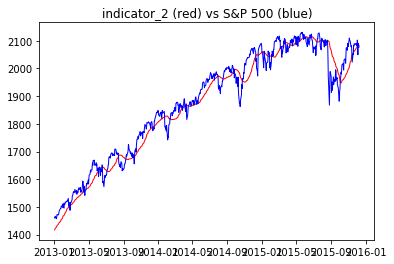

In [12]:
lr = LinearRegression()
lr.fit(train[['day_30']],train[['Close']])
pre = lr.predict(test[['day_30']])

# print(indicator_2, 'coef:', lr.coef_)
# print(indicator_2, 'intercept:', lr.intercept_)

mae_2 = mean_absolute_error(test['Close'],pre)
print(indicator_2,'mean_absolute_error:', mae_2)

mse_2 = mean_squared_error(test['Close'],pre)
print(indicator_2,'mean_squared_error:', mse_2)

plt.plot(test['Date'],pre, color='red', linewidth=1)
plt.plot(test['Date'], test['Close'], color='blue', linewidth=1)
plt.title('indicator_2 (red) vs S&P 500 (blue)')
plt.show()

From the chart above, we can see that indicator_2 has a higher mean_absolute_error and mean_squared_error, and does not track the index as closely as indicator_1.

#### indicator_3 = 'day_365'

day_365 mean_absolute_error: 146.631302068694
day_365 mean_squared_error: 24609.62854669091


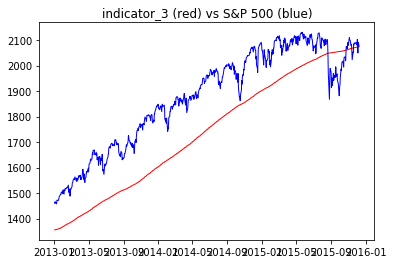

In [13]:
lr = LinearRegression()
lr.fit(train[['day_365']],train[['Close']])
pre = lr.predict(test[['day_365']])

# print(indicator_3, 'coef:', lr.coef_)
# print(indicator_3, 'intercept:', lr.intercept_)

mae_3 = mean_absolute_error(test['Close'],pre)
print(indicator_3,'mean_absolute_error:', mae_3)

mse_3 = mean_squared_error(test['Close'],pre)
print(indicator_3,'mean_squared_error:', mse_3)

plt.plot(test['Date'],pre, color='red', linewidth=1)
plt.plot(test['Date'], test['Close'], color='blue', linewidth=1)
plt.title('indicator_3 (red) vs S&P 500 (blue)')
plt.show()

From the chart above, we can see that indicator_3 has an even lower degree of accuracy of prediction than indicator_2.

#### indicator_4 = 'day_5, day_30'

day_5, day_30 mean_absolute_error: 16.149299962628422
day_5, day_30 mean_squared_error: 493.8476589907151


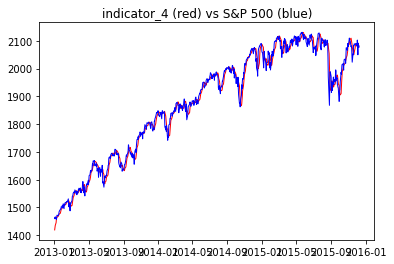

In [14]:
lr = LinearRegression()
lr.fit(train[['day_5','day_30']],train[['Close']])
pre = lr.predict(test[['day_5','day_30']])

# print(indicator_4, 'coef:', lr.coef_)
# print(indicator_4, 'intercept:', lr.intercept_)

mae_4 = mean_absolute_error(test['Close'],pre)
print(indicator_4,'mean_absolute_error:', mae_4)

mse_4 = mean_squared_error(test['Close'],pre)
print(indicator_4,'mean_squared_error:', mse_4)

plt.plot(test['Date'],pre, color='red', linewidth=1)
plt.plot(test['Date'], test['Close'], color='blue', linewidth=1)
plt.title('indicator_4 (red) vs S&P 500 (blue)')
plt.show()

#### indicator_5 = 'day_5, day_30, day_365'

day_5, day_30, day_365 mean_absolute_error: 16.14243964355453
day_5, day_30, day_365 mean_squared_error: 493.7313030125896


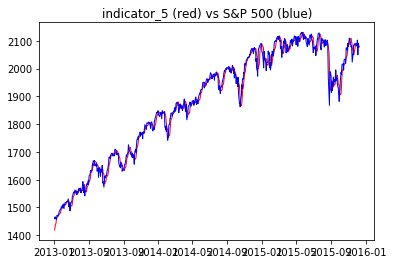

In [15]:
lr = LinearRegression()
lr.fit(train[['day_5','day_30','day_365']],train[['Close']])
pre = lr.predict(test[['day_5','day_30','day_365']])

# print(indicator_5, 'coef:', lr.coef_)
# print(indicator_5, 'intercept:', lr.intercept_)

mae_5 = mean_absolute_error(test['Close'],pre)
print(indicator_5,'mean_absolute_error:', mae_5)

mse_5 = mean_squared_error(test['Close'],pre)
print(indicator_5,'mean_squared_error:', mse_5)

plt.plot(test['Date'],pre, color='red', linewidth=1)
plt.plot(test['Date'], test['Close'], color='blue', linewidth=1)
plt.title('indicator_5 (red) vs S&P 500 (blue)')
plt.show()

#### Comparison of mean_absolute_error and mean_squared_error:

In [16]:
print(indicator_1,'mean_absolute_error:', mae_1)
print(indicator_2,'mean_absolute_error:', mae_2)
print(indicator_3,'mean_absolute_error:', mae_3)
print(indicator_4,'mean_absolute_error:', mae_4)
print(indicator_5,'mean_absolute_error:', mae_5)

day_5 mean_absolute_error: 16.267878754475266
day_30 mean_absolute_error: 31.970513557097345
day_365 mean_absolute_error: 146.631302068694
day_5, day_30 mean_absolute_error: 16.149299962628422
day_5, day_30, day_365 mean_absolute_error: 16.14243964355453


In [17]:
print(indicator_1,'mean_squared_error:', mae_1)
print(indicator_2,'mean_squared_error:', mae_2)
print(indicator_3,'mean_squared_error:', mae_3)
print(indicator_4,'mean_squared_error:', mae_4)
print(indicator_5,'mean_squared_error:', mae_5)

day_5 mean_squared_error: 16.267878754475266
day_30 mean_squared_error: 31.970513557097345
day_365 mean_squared_error: 146.631302068694
day_5, day_30 mean_squared_error: 16.149299962628422
day_5, day_30, day_365 mean_squared_error: 16.14243964355453


#### Observations:

For both mean_absolute_error and mean_squared_error, combining all 3 indicators together appears to result in the highest accuracy of the linear regression, although the improvement in accuracy compared to combining 2 indicators appears to be minimal.

In terms of individual indicators, it is unsurprising that the 5-day moving average would track the S&P500 index most closely, while the 365-day moving average results in the largest predictive error.  This can also been seen visually in the respective chart plots.